# Temple University Dataset

The Temple University Dataset is a large, open-access, dataset of clincal EEG data. 

Web link: https://www.isip.piconepress.com/projects/tuh_eeg/html/overview.shtml

Paper Overview: http://journal.frontiersin.org/article/10.3389/fnins.2016.00196/full

Ultimately, the goal will be to use this dataset, which is on a scale never really seen before in EEG datasets, to try and characterize and understand brain activity in a large cohort, across 'normal' brain activity, and disease. 

## TASKS:
The first set of tasks relates to working on a pre-processing pipeline for the data. Regardless of the set of analyses we ultimately choose, the data need to be organized, cleaned and pre-processed in such a way that we have confidence that the analyses we run reflect brain activity, not artifacts. A key goal of setting up this pipeline is that it be automatic and robust - given the number of subjects, we need to have confidence we can run this pipeline without manual supervision, and trust the data that comes out of it. 

Note: since we're using MNE, we don't want to end up with some information inside the MNE objects, and some outside them. As we develop these processes, let's try to keep a tight integration with MNE. 

### First Goal:
    - Fully clean a subject of the rest state, for example, run the PSD over the remaining channels, and trust it reflects brain activity.

### Preprocessing Tasks
Pre-processing pipeline:
  - Sort out the channel names and data types. 
      - Target output: a list of just the standard channel names (example: FP1, Cz, T4)
          - Also: Keep track of channel types. (Another list of ['EEG', 'EEG', 'EMG'])
              - Then: make sure we can put this 'back' into the MNE objects - update the channel info accordingly. 
  - What are the event markers? How do we line them up with the data? Can we epoch into different 'states'?
      - Target output: extracted epoch of resting data. 
  - How can we (automatically?) reject bad channels
      - We want to figure out MNE's available tools to reject channels, and start applying them.
      - Target output: For example subjects, channels we don't trust (visually) should be able to be 'dropped' (marked as bad so that they are ignored by future processing) by running an automatic process. 
  - How can we (automatically?) reject bad time segments
      - We want to figure out MNE's available tools to reject time segments, and start applying them.
      - Target output: For example subjects, time segments we don't trust (visually) should be dropped (again, marked bad to be ignored) by running an automatic process. 
  - How can we (automatically?) deal with stereotyped artifacts - such as eye blinks, heartbeats, saccades
      - Here I mean artifacts that we can correct for, different from time segments we decide we need to avoid.
      - We want to figure out MNE's available tools to correct for artifacts, and start applying them.
      - Target output: This depends slightly more on what is available (in the data, and in MNE), but ideally, for heartbeat and eye blinks (perhaps others), we would like to be able to automatically label them and 'subtract' them out from the data in some way - such that we can keep, and still use, these segments of data. 
      
Final outcome: A cleaned segment of resting data, ready for analysis, for 1 or 2 subjects. Working through this process will be very manually supervised, but hopefully by the time it's finished, the whole process can be re-run automatically, without human input, and this process can also be applied to other subjects. 
  
### Database Work (2nd level of task)
We will need utility functions to work with the database, to list subjects, find subjects, get paths, etc. 
- We'll work on this mainly when we want to scale up the number of subjects. Don't start it yet, I have some example code from other projects that can form a basis of this. 


### Metadata Work (3rd level of task)
Ultimately, we probably want some tools to be able to automatically scrape the clinical notes, and extract key parameters, like age, sex, and diagnoses. 
- This is not an immediate priority, as it will become more relevant as we fine-tune the analyses. We might, for example, start with the clearly labelled 'epilepsy vs non-epilepsy' group that is available, before we try to do large-scale mining of the clinical notes. 

## Notes:
- This first level of work is very pre-process-y, but required to get started with this data. Once we have a couple subjects set up with something that works at least reasonably well, we'll move on to more analysis stuff, and really get into the data, so that we're not stuck forever on pre-processing. 
- The goal is to get a rough version of the full pipeline, allowing us to 'see' the whole project, and find any major hurdles. It also, in practice, lets us try out each part of the project first, without getting bogged down at any particular step. 
- Eventually, we will have to double back and make sure each step is really robust.
- Also, soon, we will work a bit on setting up our codebase as a proper module, for organization and scalability. 

In [2]:
# Imports
%matplotlib qt
import mne
import os

In [3]:
# Set up paths

# This base path will need updating
base_path = 'C:\\Users\\Luyanda Mdanda\\Documents\\Research\\tuh_eeg'

# These should stay the same
#subj_dat_fname = 'tuh_eeg\v0.2\00000164\00000164_0.edf'
subj_dat_fname = 'tuh_eeg\\v0.2\\00000184\\00000184_0.edf'

In [9]:
# Read in an example subject of data (subject chosen randomly)
full_path = os.path.join(base_path, subj_dat_fname)
eeg_dat = mne.io.read_raw_edf(full_path)
eeg_dat.set_eeg_reference()

Extracting edf Parameters from C:\Users\Luyanda Mdanda\Documents\Research\tuh_eeg\tuh_eeg\v0.2\00000184\00000184_0.edf...
Setting channel info structure...
Creating Raw.info structure...
Ready.
Adding average EEG reference projection.
1 projection items deactivated


<RawEDF  |  00000184_0.edf, n_channels x n_times : 29 x 8960 (35.0 sec), ~58 kB, data not loaded>

In [5]:
# Check out the info object for this subject
eeg_dat.ch_names

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG T1-REF',
 'EEG T2-REF',
 'EEG FZ-REF',
 'EEG CZ-REF',
 'EEG PZ-REF',
 'EEG EKG1-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'PHOTIC-REF',
 'IBI',
 'BURSTS',
 'SUPPR',
 'STI 014']

In [14]:
# Example of one way to start fixing up the channels
#  Priority again is to keep everything consistent with MNE, so first check for MNE functions that can do 
#   things like this, and that can update this information insode the data.info object. 


channel_names = []
channel_types =[]

# lists to store the array names

for ch in eeg_dat.ch_names:    
    if 'EEG' in ch:
        ch = ch[4:7]
        ch =''.join(e for e in ch if e.isalnum())
        channel_names.append(ch)
        channel_types.append('eeg')
        
    elif 'EMG' in ch:
        ch = ch[4:7]
        ch =''.join(e for e in ch if e.isalnum())
        channel_names.append(ch)
        channel_types.append('emg')
        # Keeps track that this is an EMG channels
        
    elif 'STI' in ch:
        channel_names.append(ch)
        channel_types.append('stim')
        # Keeps track that this is an STI channel
    
    else:
        channel_names.append(ch)
        channel_types.append('misc')
        # Keeps track of MISC channels
        
# The EEG channels use the standard naming strategy.
# By supplying the 'montage' parameter, approximate locations
montage = 'standard_1020'

print (channel_names)


info = mne.create_info(channel_names, eeg_dat.info['sfreq'], channel_types, montage)
print(info)

['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'T1', 'T2', 'FZ', 'CZ', 'PZ', 'EKG', 'A1', 'A2', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR', 'STI 014']
The following EEG sensors did not have a position specified in the selected montage: ['FP1', 'FP2', 'T1', 'T2', 'FZ', 'CZ', 'PZ', 'EKG']. Their position has been left untouched.
<Info | 15 non-empty fields
    bads : 'list | 0 items
    ch_names : 'list | FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2
    chs : 'list | 29 items (STIM: 1, MISC: 4, EEG: 24)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : 'list | 0 items
    highpass : 'float | 0.0 Hz
    hpi_meas : 'list | 0 items
    hpi_results : 'list | 0 items
    lowpass : 'float | 128.0 Hz
    meas_date : 'numpy.ndarray | 1969-12-31 16:00:00
    nchan : 'int | 29
    projs : 'list | 0 items
    sfreq : 'float | 256.0 Hz
    acq_pars : 'NoneType
    acq_stim :

<ipython-input-14-4adc77a0006a>:42: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['FP1', 'FP2', 'T1', 'T2', 'FZ', 'CZ', 'PZ', 'EKG']. Their position has been left untouched.
  info = mne.create_info(channel_names, eeg_dat.info['sfreq'], channel_types, montage)


(29, 2560)
(2560,)


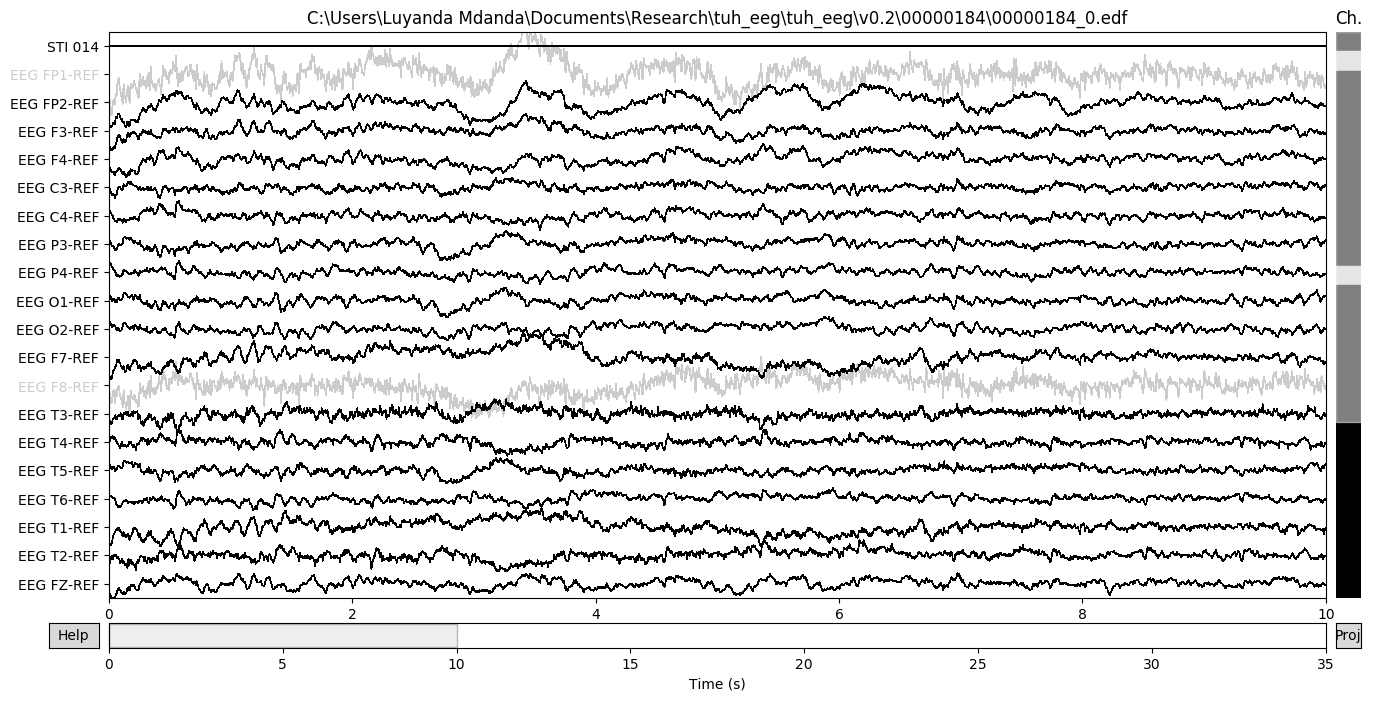

In [45]:
start, stop = eeg_dat.time_as_index([0, 10])  # 0 s to 10 s data segment
data, times = eeg_dat[:, start:stop]
print(data.shape)
print(times.shape)
data, times = eeg_dat[2:20:3, start:stop]  # access underlying data
eeg_dat.plot()

In [44]:
# Creates events at a 1 second as current data doesn't have any avaialble

events = mne.make_fixed_length_events(eeg_dat, 1, start = 0, stop = None, duration = 1.0, first_samp = True)
print(events[:10])

[[   0    0    1]
 [ 256    0    1]
 [ 512    0    1]
 [ 768    0    1]
 [1024    0    1]
 [1280    0    1]
 [1536    0    1]
 [1792    0    1]
 [2048    0    1]
 [2304    0    1]]


In [47]:
# De
event_id = dict(aud_l=1, aud_r=2)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

In [48]:
picks = mne.pick_types(eeg_dat.info, meg=False, eeg=True, eog=True, stim=False,
                       exclude='bads')

In [49]:
baseline = (None, 0)  # means from the first instant to t = 0

In [52]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

In [54]:
epochs = mne.Epochs(eeg_dat, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=False,  reject=reject)
print(epochs)

ValueError: No matching events found for aud_r (event id 2)